In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


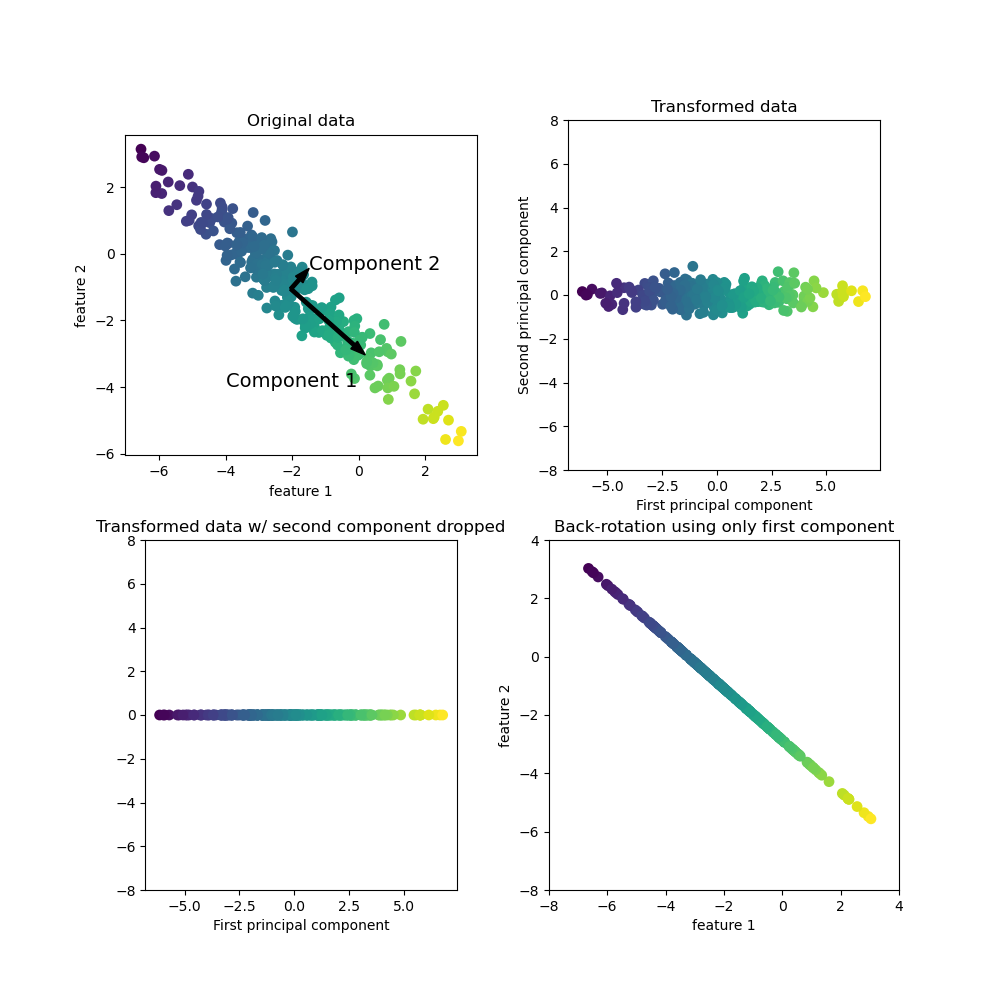

In [3]:
mglearn.plots.plot_pca_illustration()

三枚目(左下)では、一つ目の主成分を残している。  
元の特徴量のうち1つを残しているわけではなく、最も興味深い方向(左上から右下の向き)を残している。

## cancerデータセットのPCAによる可視化
- このデータセットには特徴量が30もあり、ペアプロットすら難しい
- 特徴量ごとに、２クラスのヒストグラムを書いてみる


<IPython.core.display.Javascript object>


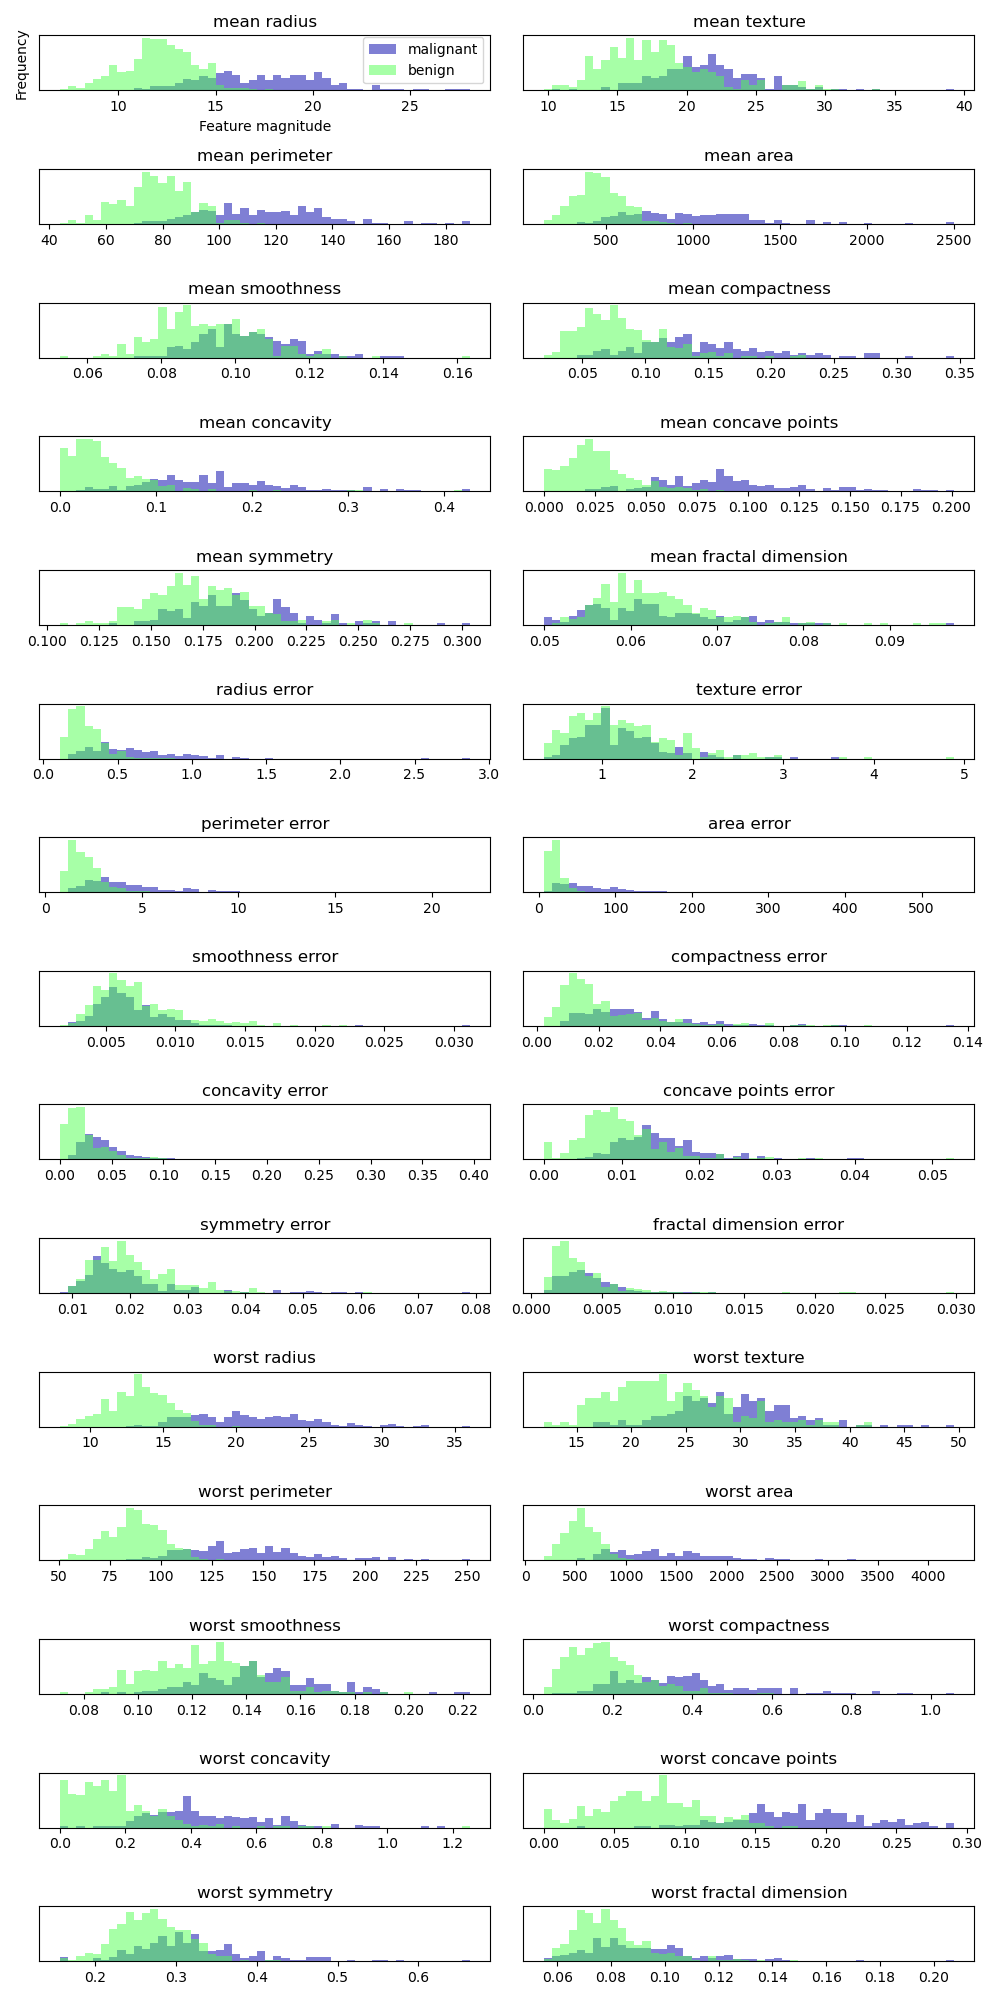

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

個々のデータポイントの特徴量が特定のレンジ（ビンと呼ぶ）に何回入ったかを数える
ことで、特徴量ごとにヒストグラムを作っている  

このプロットだけを見ても、個々の特徴量の相関や、それがクラス分類に与える影響についてはよくわからない。  

PCAを用いると、主な相関を捉えることができるので、もう少し全体像が見やすくなる。   
最初の2つの主成分を用いて、2次元空間上の1つの散布図として見てみる。

In [7]:
# 平均を0に分散を1に前処理
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

- PCAオブジェクトを生成し、fitメソッドを呼び出して主成分を見つけ、transformメソッドを呼んで回転と次元削減を行う

In [9]:
from sklearn.decomposition import PCA
# データの最初の2つの主成分だけ維持する
pca = PCA(n_components=2)
# cancerデータセットにPCAモデルを適合
pca.fit(X_scaled)
# 最初の2つの主成分に対してデータポイントを変換
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


<IPython.core.display.Javascript object>


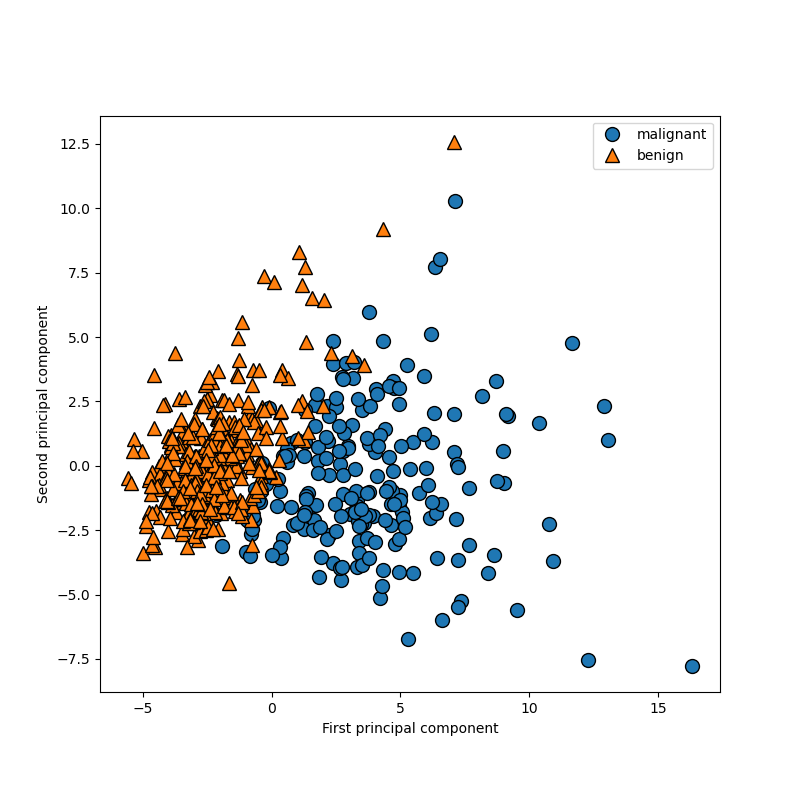

Text(0, 0.5, 'Second principal component')

In [10]:
# 第1主成分と第2主成分によるプロット。クラスごとに色分け
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


- 適切な回転を発見する際にはまったくクラス情報を用いていない。データの相関を見るのみ。
- 散布図を見ると、この第1成分と第2成分を用いた二次元空間では、この２クラスは綺麗に分離できていることがわかる。
- PCAの欠点は、主成分の方向がもとの特徴量をどのようにして組み合わせているのか解釈しづらい点

### 主成分が、元の特徴量をどう組み合わせて作られたのか

In [13]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


- components_のそれぞれの行が1つの主成分に対応
- 列は元の特徴量

In [14]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


<IPython.core.display.Javascript object>


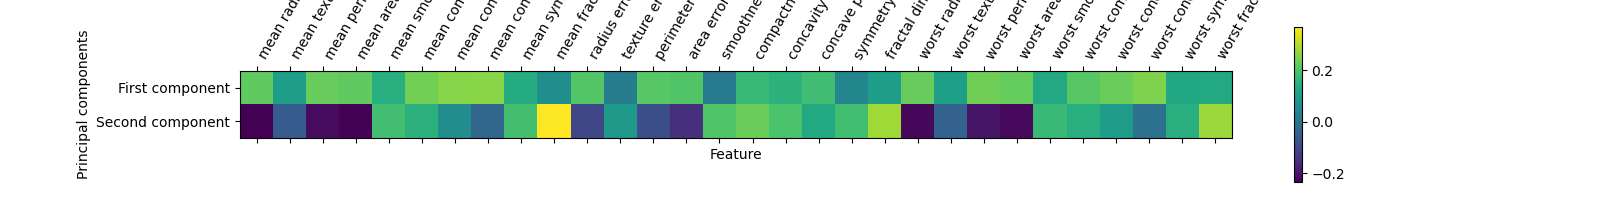

Text(0, 0.5, 'Principal components')

In [15]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

係数をヒートマップで見たもの

- 第1主成分は全て正であり、すべての元の特徴量に一般的な相関がある
- 第2主成分の符号は入り混じっている。  
また、両方とも30の特徴量すべてが混ざっているため、先ほどの軸の意味を説明するのは非常に難しい

## 固有顔による特徴量抽出

PCAを用いた画像からの特徴量抽出のとても簡単なアプリケーション  
以下は画像の例

<IPython.core.display.Javascript object>


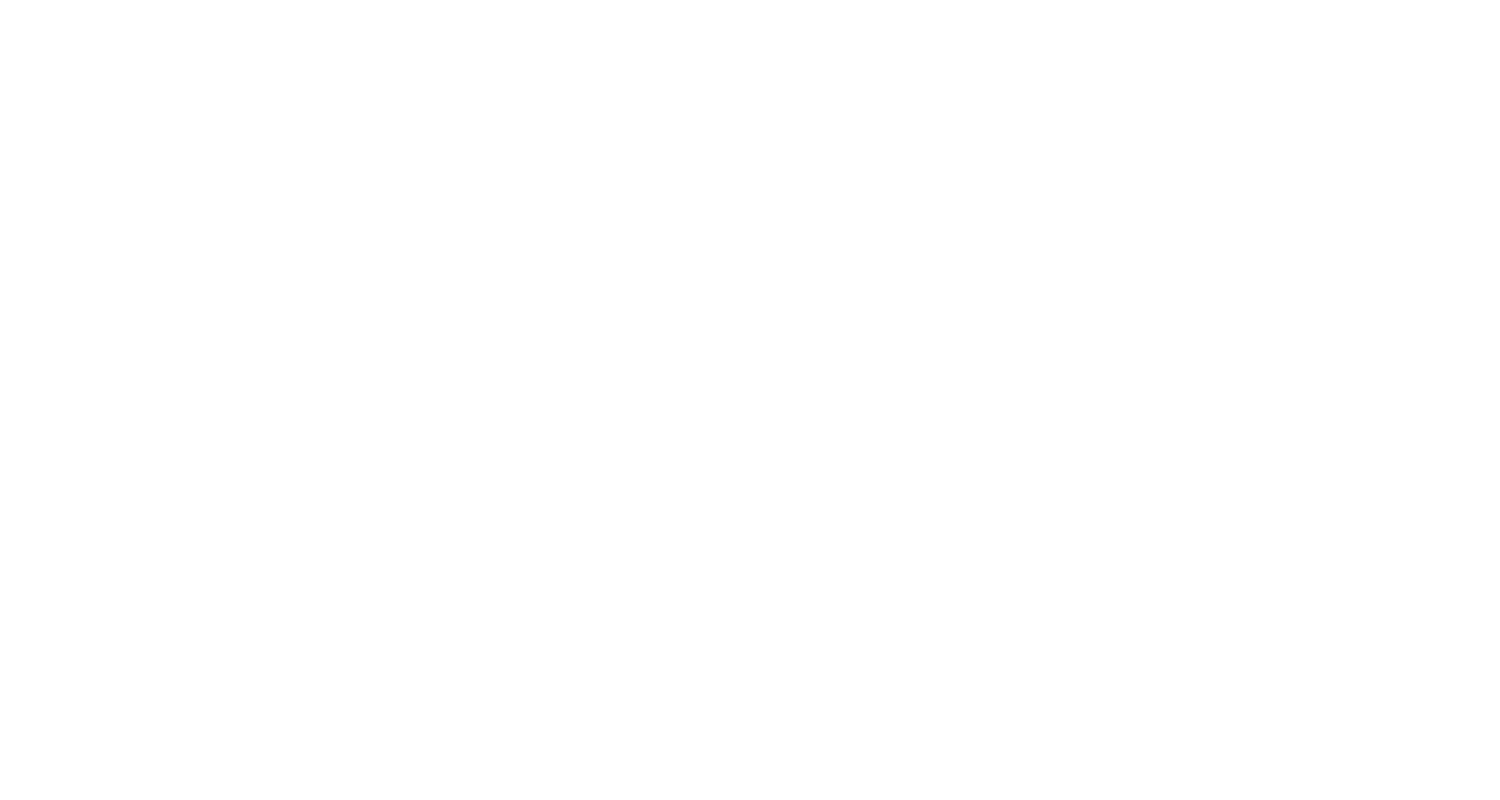

In [28]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [29]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [30]:
people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [31]:
people

{'data': array([[ 57.      ,  60.333332,  78.      , ...,  17.333334,  16.666666,
          22.666666],
        [ 66.666664,  80.666664,  88.666664, ...,   8.666667,   8.333333,
           9.333333],
        [ 18.666666,  14.333333,  15.      , ...,  22.666666,  22.666666,
          25.666666],
        ...,
        [ 77.333336,  90.333336,  93.333336, ..., 233.66667 , 234.33333 ,
         230.66667 ],
        [ 87.666664,  71.666664,  63.333332, ...,  96.      ,  92.333336,
          96.333336],
        [ 91.      ,  90.666664,  94.666664, ...,  40.333332,  42.333332,
          42.333332]], dtype=float32),
 'images': array([[[ 57.       ,  60.333332 ,  78.       , ...,  40.666668 ,
           36.666668 ,  34.       ],
         [ 52.666668 ,  60.       ,  92.       , ...,  46.666668 ,
           36.       ,  30.       ],
         [ 46.       ,  66.       , 113.333336 , ...,  51.       ,
           43.333332 ,  37.666668 ],
         ...,
         [ 61.       ,  62.666668 ,  62.333332 , .

In [32]:
people["DESCR"]

".. _labeled_faces_in_the_wild_dataset:\n\nThe Labeled Faces in the Wild face recognition dataset\n------------------------------------------------------\n\nThis dataset is a collection of JPEG pictures of famous people collected\nover the internet, all details are available on the official website:\n\n    http://vis-www.cs.umass.edu/lfw/\n\nEach picture is centered on a single face. The typical task is called\nFace Verification: given a pair of two pictures, a binary classifier\nmust predict whether the two images are from the same person.\n\nAn alternative task, Face Recognition or Face Identification is:\ngiven the picture of the face of an unknown person, identify the name\nof the person by referring to a gallery of previously seen pictures of\nidentified persons.\n\nBoth Face Verification and Face Recognition are tasks that are typically\nperformed on the output of a model trained to perform Face Detection. The\nmost popular model for Face Detection is called Viola-Jones and is\ni

このデータセットは少し偏っており、ジョージ・W・ブッシュとコリン・パ
ウエルの画像が多い

In [35]:
# 各ターゲットの出現回数をカウント
counts = np.bincount(people.target)
# ターゲット名と出現回数を並べて表示
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

In [36]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
     mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# 0から255で表現されている、グレースケールの値0と1の間に変換
# こうしたほうが、数値的に安定する
X_people = X_people / 255.

__顔認識の一般的なタスク__：見たことのない顔が、データベース中の人物と一致するかを判別する  
この問題を解く1つの方法は、個々の人物を異なるクラスとして、クラス分類器を訓練することである。  
だが、多くの場合、同じ人物の画像は少なく訓練が難しい  

簡単な方法として、1-最近傍法クラス分類器を使う方法がある。  
クラス分類しようとしている顔に一番近い顔を探す

In [37]:
from sklearn.neighbors import KNeighborsClassifier
# 訓練セットとテストセットにデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
# KNeighborsClassifierを1-最近傍で構築
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


C:\Users\yy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<IPython.core.display.Javascript object>


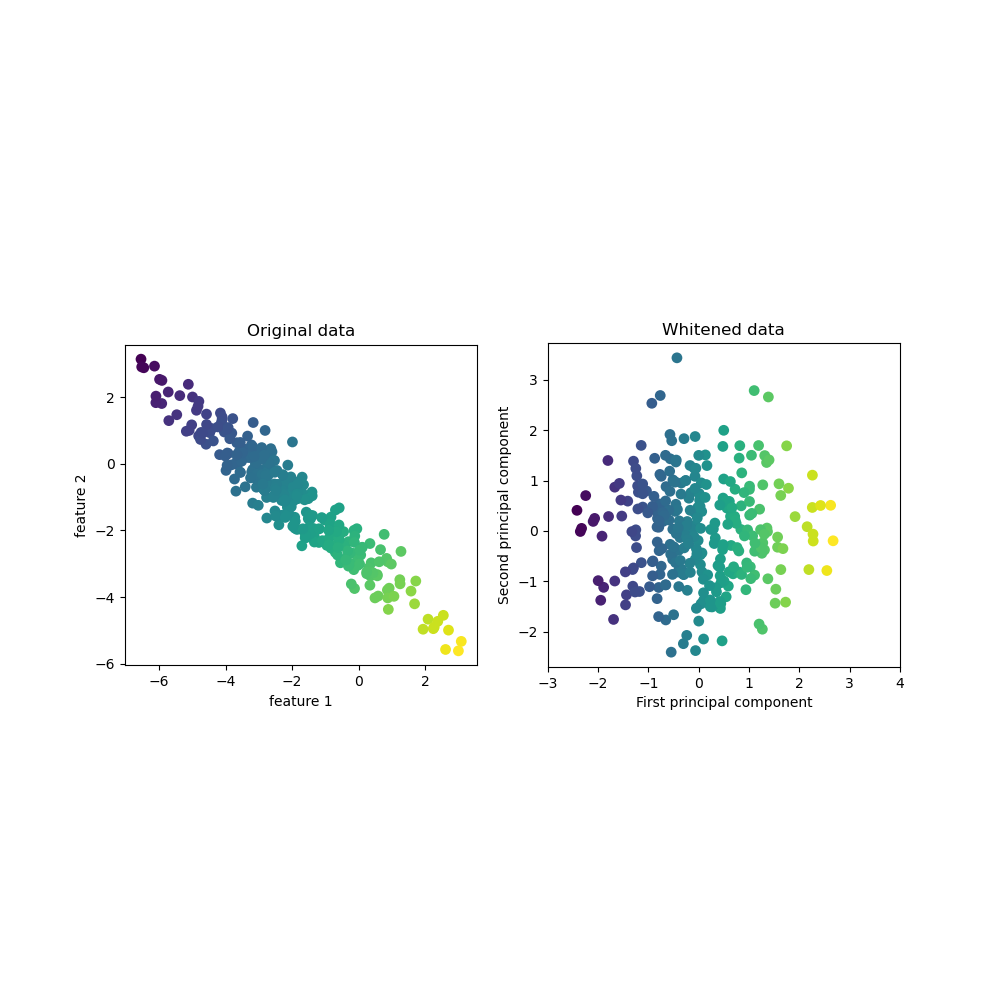

In [38]:
## 元のピクセルの空間で距離を計算するのではなく、主成分が同じスケールになるようにスケール変換を施す。
mglearn.plots.plot_pca_whitening()

In [39]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [40]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


C:\Users\yy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


- 精度が向上
- 主成分の可視化  
入力空間は、87×65ピクセルのグレースケール画像なので、この空間での方向は、87×65ピクセルのグレースケール画像になる

In [41]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


fix, axes = plt.subplots(3, 5, figsize=(15, 12),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

1.顔と背景のコントラスト  
2.光の当たり方による左右の明るさの差  
などと解釈できるが、人間が人間の顔を解釈する方法とはかなり違う(ピクセルに表れづらい、性別や年齢などのような属性を考えるため)

In [43]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

Text(1139.1522988505747, 0.5, 'Second principal component')

## t-SNEを用いた多様体学習

t-SNE多様体学習をscikit-learnに入っている手書き数字データセット（digitsデータセット）
に適用してみる。  
このデータセットの個々のデータポイントは8×8のグレースケールの0から9までの手書き数字である  


まずは、PCAを用いて主成分2つで可視化

<IPython.core.display.Javascript object>


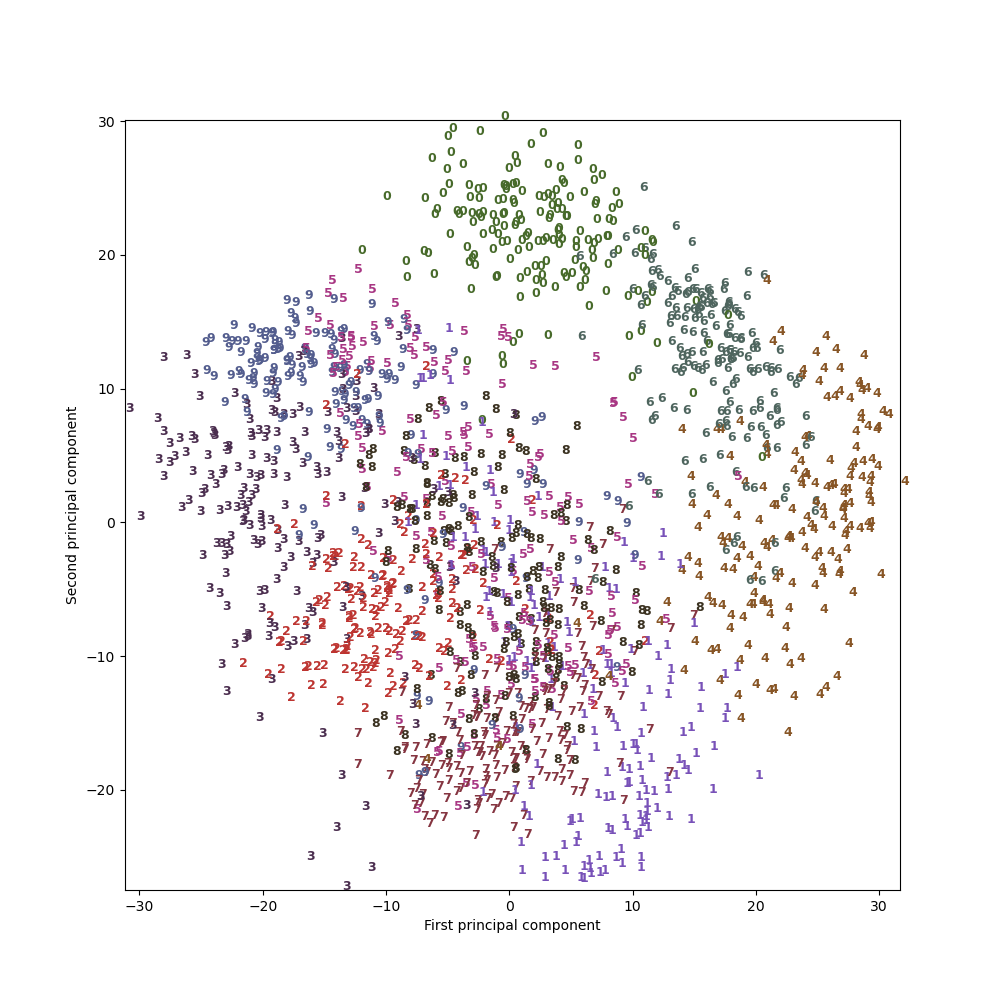

Text(0, 0.5, 'Second principal component')

In [47]:
from sklearn.datasets import load_digits
digits = load_digits()

# PCAモデルを構築
pca = PCA(n_components=2)
pca.fit(digits.data)
# 数値データを最初の2主成分で変形
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
# 散布図を数字でプロット
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
            color = colors[digits.target[i]],
            fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


結果を比較するために、同じデータセットに対してt-SNEを適用してみる。  
t-SNEは新しいデータの変換をサポートしていないので、TSNEクラスにはtransformメソッドがない  
(訓練に使うデータの変換しかできない)

In [48]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# fitではなくfit_transformを用いる。TSNEにはtransformメソッドがない
digits_tsne = tsne.fit_transform(digits.data)

C:\Users\yy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


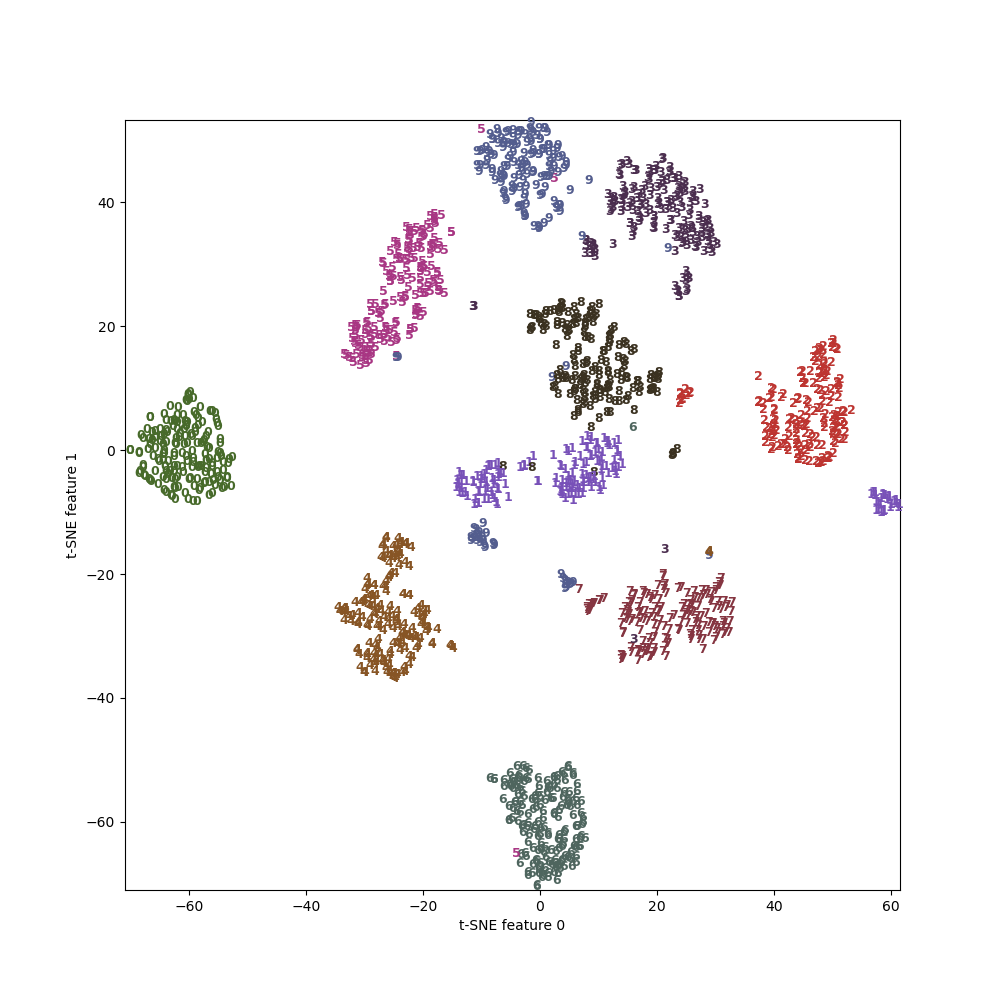

Text(0, 0.5, 't-SNE feature 1')

In [49]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
 # 点ではなく数字をテキストとしてプロットする
     plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

クラスラベルを使わず、データをクラスごとに綺麗に分離して2次元に表現した。  
すごい